In [1]:
'''
Ziff Intern 2017 - Task 02

Trains a simple convnet on the CIFAR10 dataset for ONLY cats and dogs.
The focus of this is to understand image augmentation well enough to do custom work.

So don't worry as much about accuracy, worry more about adding augmentation to the existing method, 
understanding it, explaining it, and if it is significant enough, then trying to merge it into Keras.

TASK DETAILS:
Make a copy of:
from keras.preprocessing.image import ImageDataGenerator

Add functionality to ImageDataGenerator() beyond what is offered. You have flexibility here, one idea would be to add image 
histogram modification methods such as this: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

You are welcome to do anything you want related to ImageDataGenerator to make it better, but histogram modification could be a great
starting point. With your work it helps to show before/after modifications in your notebook/blog. In the end this work is for
you, to help give you visibility, so focus more on something that can be shared on LinkedIn rather than just a notebook. 

13 seconds per epoch on a 2 GHz Intel Core i5.
'''

"\nZiff Intern 2017 - Task 02\n\nTrains a simple convnet on the CIFAR10 dataset for ONLY cats and dogs.\nThe focus of this is to understand image augmentation well enough to do custom work.\n\nSo don't worry as much about accuracy, worry more about adding augmentation to the existing method, \nunderstanding it, explaining it, and if it is significant enough, then trying to merge it into Keras.\n\nTASK DETAILS:\nMake a copy of:\nfrom keras.preprocessing.image import ImageDataGenerator\n\nAdd functionality to ImageDataGenerator() beyond what is offered. You have flexibility here, one idea would be to add image \nhistogram modification methods such as this: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html\n\nYou are welcome to do anything you want related to ImageDataGenerator to make it better, but histogram modification could be a great\nstarting point. With your work it helps to show before/after modifications in your notebook/blog. In the end this work 

In [2]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.datasets import cifar10

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import warnings
from skimage.io import imread
from skimage import exposure, color
from skimage import data, img_as_float

Using TensorFlow backend.


# Load and preprocess CIFAR10 image data

In [3]:
batch_size = 64
num_classes = 2
epochs = 10

# input image dimensions
img_rows, img_cols = 32, 32   

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()   

#Only look at cats [=3] and dogs [=5]
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     

y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(np.ravel(y_train), num_classes)
y_test = keras.utils.to_categorical(np.ravel(y_test), num_classes)

x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples


# Construct CNN model

In [4]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Define function for constrast adjustment

In [5]:
# Contrast stretching
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

# Histogram equalization
def HE(img):
    img_eq = exposure.equalize_hist(img)
    return img_eq


# Adaptive histogram equalization
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

# Train model with image augmentation

In [6]:
augmentation=True

if augmentation==True:
    datagen = ImageDataGenerator(
            rotation_range=0,
            width_shift_range=0,
            height_shift_range=0,
            shear_range=0,
            zoom_range=0,
            horizontal_flip=True,
            fill_mode='nearest',
#             preprocessing_function = contrast_adjusment,
#             preprocessing_function = HE,
            preprocessing_function = AHE)

    datagen.fit(x_train)
    
    print("Running augmented training now, with augmentation")
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
else:
    print("Running regular training, no augmentation")
    history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Running augmented training now, with augmentation
Epoch 1/10


/Users/sukilau/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


156/156 [==============================] - 177s - loss: 0.6970 - acc: 0.5083 - val_loss: 0.6925 - val_acc: 0.5040

# Visualize model accuracy

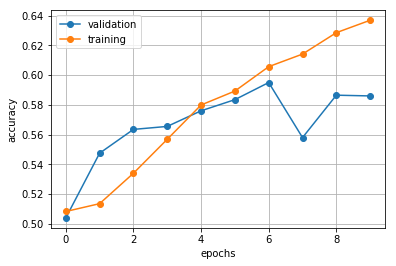

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

plt.plot(history.epoch,history.history['val_acc'],'-o',label='validation')
plt.plot(history.epoch,history.history['acc'],'-o',label='training')

plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)